# AR Models

- Describe what an autoregressive model is
- Fit and evaluate an AR model
- Define what order means for time series

## Autoregressive Models

- AR models are designed to create a liner regression for time series.
- In timee series models the target 'y' is also used to generate the time-lagged features.
- AR models create a linear model that includes a constant and new type of time-lag coefficient.

**Defining Model 'Order'**
- The simple equation for an AR model has the constant, noise, and coefficient times previous value.
- Like linear regression with sklearn, more coefficients can be included with more accompanying time lags.
- The number of time lags to include is the 'order' of the AR model, abbreviated AR(#) where # is the order.
- This lesson will make use of a class of models called ARIMA, which stands for 'Auto-Regressive Integrated Moving-Average'
    - 'moving-average' will be covered in a later lesson
    - 'integrated' refers to differencing done to make the data stationary.

**Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

**Custom Functions**

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

**Load Data**

In [3]:
# Load in data
ts = pd.read_csv('Data/AR_lesson_ts.csv', index_col = 'date')
ts.head()

,dollars
date,
2020-01-05,0.422207
2020-01-12,-0.455290
2020-01-19,0.914767
2020-01-26,0.562761
2020-02-02,-0.649239


- Turn the data into a time series with the index as a DateTime object with a weekly frequency.

In [4]:
# Make index datetime
ts.index = pd.to_datetime(ts.index)
# We have weekly data so we will set our frequency to W
ts.index.freq= "W"
# Make a series
ts = ts['dollars']

**Check for null values**

In [5]:
ts.isna().sum().sum()

0

**Visualize Time Series**

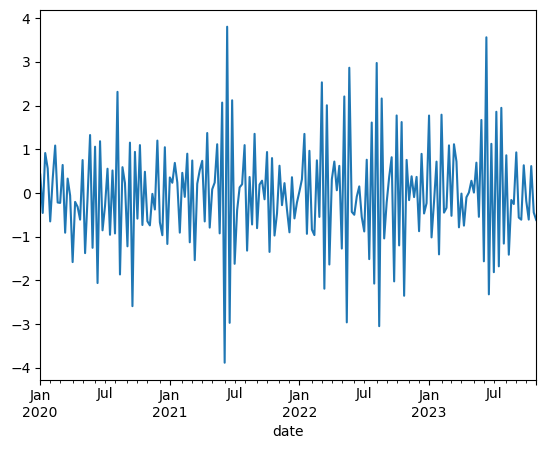

In [6]:
# Plot the time series
ts.plot();

- There are many fluctuations, but no apparent pattern. If the data had a seasonal component, it could be included in the model (more about modeling in a future lesson).
- Check the ACF Plot for seasonality as well.

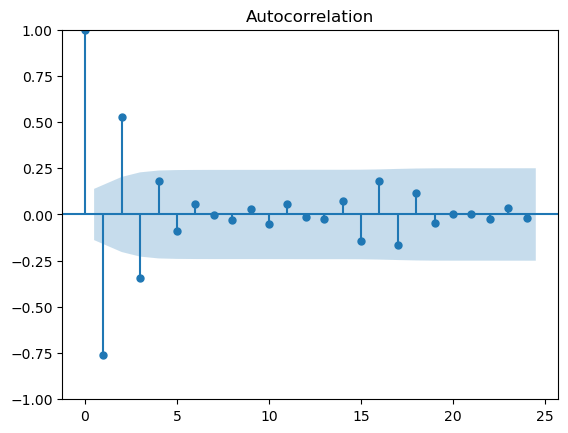

In [7]:
# Make ACF Plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

- There doesn't appear to be any seasonality in this plot either. Move on to checking stationarity with ADFuller.

In [8]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


- This data is stationary, without any need for differencing.
- Another option available is a tool that calculates the number of times data needs to be differenced to be stationary.
    - Import the 'ndiffs' function from pmdarima.arima.utils

In [9]:
from pmdarima.arima.utils import ndiffs
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 0


**Estimate Orders**
- Once the data is stationary, the order to ask from the model can be estimated.
- Ultimately, two plots will be compared to decide whether a model is an AR, MA, or combination ARMA model.
- Begin by looking at the ACF of stationary data.

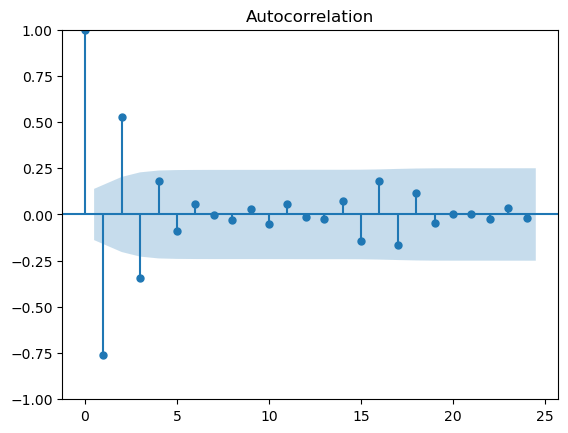

In [10]:
# Make acf plot to determine is this is AR or MA
tsa.graphics.plot_acf(ts);

- There is significant autocorrelation in the data, but some points must be considered first:
    1. Does the magnitude of the values drop off suddenly; or,
    2. Does the magnitude of the values gradually get smaller and smaller?


- It can be hard to see with both positive and negative values, but the above example shows a gradual decrease in magnitude.
- When this is visible in ACF plots, it indicates that an auto-regressive (AR) model is likely appropriate.

**PACF**
- Examine a variation of the ACF plot, the PACF plot (Partial AutoCorrelation Function).

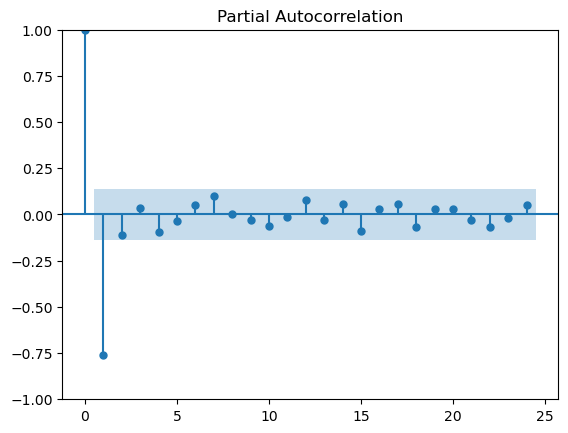

In [11]:
# Examine the PACF plot to determine order of AR model
tsa.graphics.plot_pacf(ts);

- After plotting PACF, ask:
    1. Does the magnitude of values drop off suddenly; or,
    2. Does the magnitude of values gradually decrease?
- The PACF plot above shows a very abrupt drop after Lag 1.
    - This indicates only one coefficient is needed in the AR model, also then called an AR(1) model.

**Validation Split**
- True time-series models, like AR models, no longer use an X and Y variable. Recall there is no random split, but a split of older and more recent time values.
- Here, split the oldest 80% of data for training and leave 20% for testing.

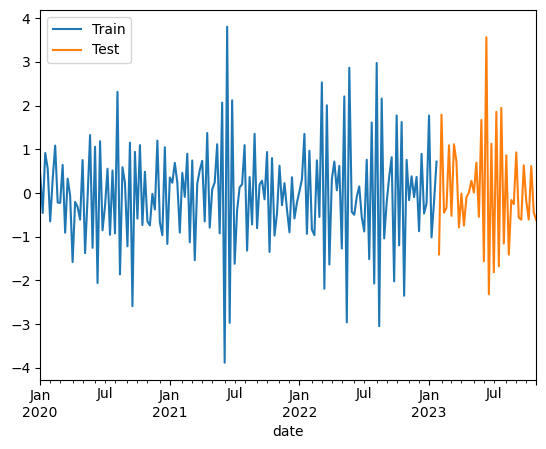

In [12]:
from pmdarima.model_selection import train_test_split
# tts
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

**Statsmodels**
- This lesson will cover the use of Statsmodels time series models. The syntax for creating a model is different than with scikit-learn.
- Statsmodels requires the data during *instantiation* and does not accept data inside the .fit()

In [13]:
# Proper way to import tsa submodule
import statsmodels.tsa.api as tsa

## ARIMA (AR Only)

- This example starts by creating an AR(1) model
- This model will be created from an instance of the ARIMA class. It can perform more than just AR models, and, therefore, requires more than just the order of the AR model (p).
- An ARIMA models' order is defined by 3 paramters: (p, d, q)
    - AD(p): an auto-regressive component, building coefficients for previously lagged values
    - Integreation(d): applying differencing to achieve stationarity
    - MA(q): a moving average component, building coefficients based on the models' errors at previous time lags.
- Currently the AR model is the goal, so use p=0.
- The time series was stationary without differencing, so d=0.
- As mentioned above, p is the order for the AR model. To create an AR(1) model, first create an ARIMA model with p=1 and 0's for the 2 remaining parameters: `ARIMA(1,0,0)`
- Pass in training data and model order during instantiation. For statsmodels models, chain on the .fit() to the model instantiation as shown here:
    - `model = tsa.ARIMA(train, order=(p,d,q)).fit()`

In [14]:
# First define the orders (p,d,q)
p = 1 # AR(1) model based on significant lags in PACF
d = 0 # No differcing needed to make stationary
q = 0 # q will be used for MA models (set to 0 for an AR only model)
# Now instantiate the model with the data and fit
ar_1_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_1_model

- The above code has generated an ARIMA model. Use model.params to see what the model has calculated.

In [15]:
# Obtain the parameters of the fit model
ar_1_model.params

const    -0.033178
ar.L1    -0.754862
sigma2    0.626342
dtype: float64

- const: The constant
- ar.L1: The single AR coefficient in this model
- sigma2: The residuals

**How to get a Forecast from an ARIMA Model**
- A simple forecast can be gotten with .forecast()
- Preferable is to obtain the forecast along with confidence interval associated with the forecast, so .get_forecast() will be used instead.
- Chaining .summary_frame() will display the results in an easy-to-read dataframe

- Also required is an int value for 'steps', the exact number of time lags to predict into the "future" (past the end of the training data). This will be the same time points as the test data.
- Therefore, it's possible to define the steps as the length of the test set.

In [16]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = ar_1_model.get_forecast(steps=len(test)).summary_frame()
forecast_df.head()

dollars,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-29,-0.600555,0.791418,-2.151706,0.950595
2023-02-05,0.395113,0.991585,-1.548359,2.338585
2023-02-12,-0.356479,1.089316,-2.491499,1.778541
2023-02-19,0.210869,1.141267,-2.025974,2.447712
2023-02-26,-0.217400,1.169839,-2.510242,2.075441


- The next goal is to visualize thwe forecasts and compare predictions with the true values from the test period.
- Below is a custom function for this purpose.

In [17]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

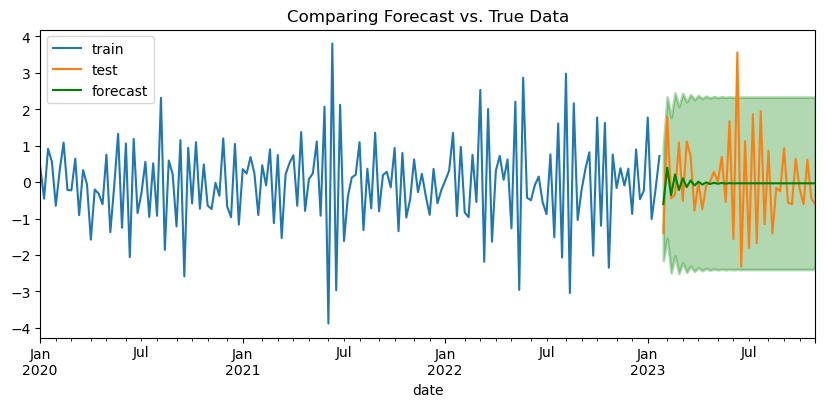

In [18]:
## Test the custom function
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

- Despite a few random fluctuations, most of the values were within the predicted confidence interval range.

**Model Evaluation**
- There is another metric that can be used to evaluate linear regression time series models. This is Mean Absolute Percentage Error, or MAPE.
- MAPE calculates the absolute error, relative to the true value.
- MAPE can be especially useful because the units of the data don't need to be known.

In [19]:
## Update the previous function for regression metrics to include MAPE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

- Test the updated function

In [20]:
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.905
- MSE = 1.354
- RMSE = 1.164
- R^2 = 0.035
- MAPE = 120.08%


- This is a poor MAPE score, but it fits the model. This was simply a simulated set, with a lot of noise that the model was unable to capture.

## Summary

- This lesson covered interpreting PACF plots ***of stationary data*** to estimate the order for an AR model.
- Remember that if the data needs to be differenced to be stationary, it's worth inspecting the plots of the differenced data.

# MA (Moving Average) Models

- Apply ARIMA's built-in differencing with the d parameter
- Build and evaluate an MA-only model (0, d, q)
- Interpret an ACF plot to estimate q
- Build and evaluate an AR-MA model (p, d, q)

### MA Models

- While MA and AR models both make predictions on future time lags, they do so with different methods.
- AR models use the true values of the target series, while
- MA models create their own forecasts and use the *errors* of those forecasts to construct additional coefficients.
- In other words, MA models see how incorrect yesterday's prediction was (the residual) and includes that in tomorrow's prediction.
- The MA model is different from a calculated "rolling mean". It could be described as the weighted sum of today's and yesterday's noise.
- The major takeaway in understaning how an MA model works is that it is fitting a regression using the residuals/errors of the previous forecasted values.
- The major parameter to determine is the number of time lags to include in the MA model, which is refered to as 'q'

### Loading, Imports, Preparation

**Imports**

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split

**Custom Functions**

In [22]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [24]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

**Load and Prepare Data**

In [25]:
# Load in data
ts = pd.read_csv('Data/MA_lesson_ts.csv', index_col = 'date')
ts.head()

,value
date,
2000-01-31,0.332798
2000-02-29,0.057122
2000-03-31,0.691783
2000-04-30,1.132335
2000-05-31,0.692867


In [26]:
ts.index = pd.to_datetime(ts.index)
# We have monthly data so we will set our frequency to M
ts.index.freq= "M"
# Define the series
ts = ts['value']

In [27]:
# Check for nulls
ts.isna().sum()

0

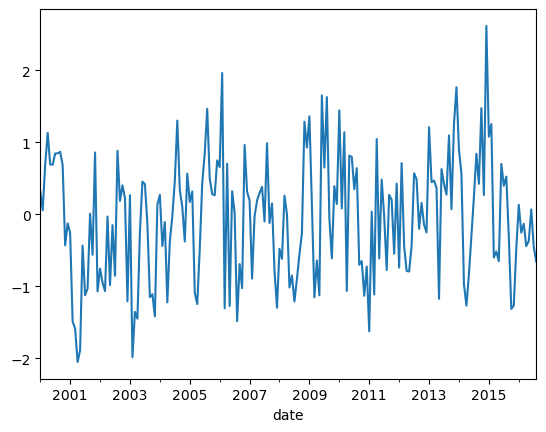

In [28]:
# Visualize the time series and look for seasonality
# Plot the time series
ts.plot();

- There are no obvious pattern in the plot. We can also check the ACF plot for any cycles.

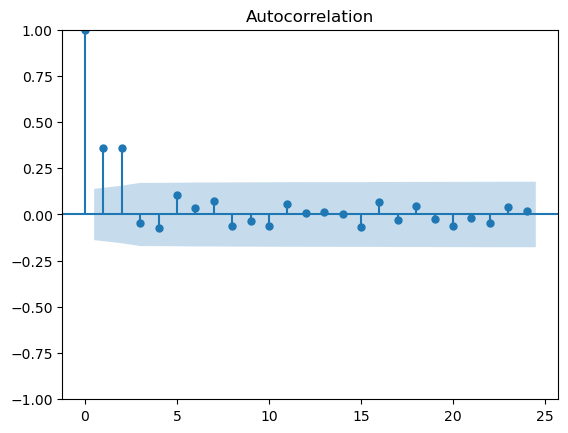

In [29]:
# Make an ACF plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

- No indication of seasonal patterns in the ACF plot.

### Check for stationarity

- Now, check for stationarity and determine the number of differencings, d, required to make the data stationary.

In [30]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-4.254855,9,190,0.000531,0.05,True


In [31]:
# Alternatively, check using ndiffs
d = ndiffs(ts)
print (f'd = {d}')

d = 0


**Determining MA Order Using Autocorrelation**
- Autocorrelation Function plots are commonly used to analyze correlation between a time series and it's lagged values.
- Can be useful when assessing the Moving Average component of a time series model.
- Note: If using differenced data inside the model, be sure to use the differenced data during EDA tasks.

**Estimating Orders**
- Create a custom function to read and compare ACF and PACF plots.

In [32]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig


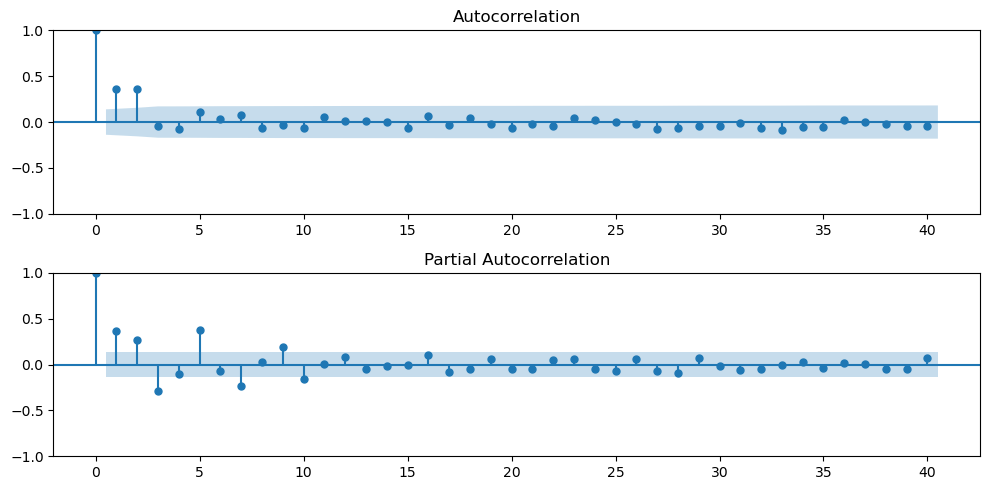

In [33]:
## Test the new function
# Call the custom acf/pacf plot on the stationary (d=0) data
plot_acf_pacf(ts);

- Examine the figures together and consider:
    1. Does the magnitude of the values drop off suddenly? Or,
    2. Does the magnitude of the values gradually get smaller and smaller?

- In this case, the ACF has a clear and distinct dropoff, while the PACF has a gradual decrease.
- This indicates that a Moving Average (MA) model would be a good choice (chart in lesson platform).

### Train Test Split

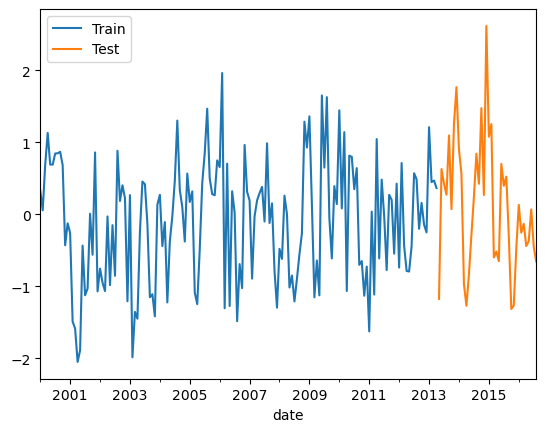

In [34]:
# TTS
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

**MA-only Model**
- Recall that the ARIMA model's order is defined by 3 parameters (p, d, q):
    - AR(p): an auto-regressive component, building coefficients for previous lagged values
    - Integration(d): applying differencing to achieve stationarity
    - MA(q): a moving average component, building coefficients based on the models' errors at previous time lags

- To create an MA model with an order of 2 and a differencing of 0, use `order=(0,0,2)`
- By setting p=0, it will be an MA-only model with no AR component.

- Statsmodels has default assumptions when fitting a time series, and one is 'invertability' where a model's coefficients could be calculated as an AR model instead of an MA model. This is unnecessary for our task so it will be turned off with enforce_invertability set to False.

In [36]:
# First define the orders (p,d,q)
p = 0 # p is used for AR models (set to 0 for an MA only model)
d = 0 # no differcing was required to make the data stationary
q = 2 # q based on significant lags in ACF
# Now instantiate the model with the data and fit
ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ma_2_model

In [37]:
## Check the model params
# Obtain the parameters of the fit model
ma_2_model.params

const    -0.105130
ma.L1     0.446952
ma.L2     0.946894
sigma2    0.379158
dtype: float64

- This differs from the AR(1) model in the prior lesson. Here two MA coeffs corresponding to q value of 2 were used for the MA(2) model.

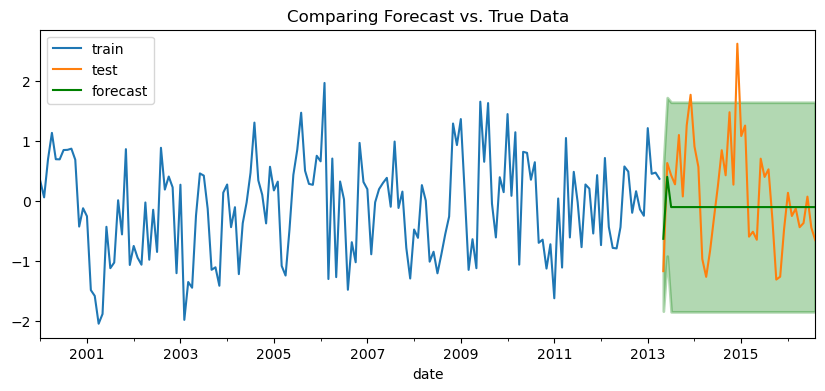

In [38]:
## Examine the forecast
# Obtain forecast as a dataframe with confidence intervals
forecast_df = ma_2_model.get_forecast(steps=len(test)).summary_frame()
# Call custom func to plot forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

### Combining AR and MA models

- AR and MA models can be combined into an ARMA model, which has both autoregressive and moving average coeffs.

In [39]:
# Load in data
ts = pd.read_csv('Data/AR_MA_lesson_ts.csv', parse_dates = ['date'], index_col = 'date')
ts.head()

,value
date,
2022-05-25,-0.148001
2022-05-26,-0.187799
2022-05-27,-0.034606
2022-05-28,0.304207
2022-05-29,0.228702


In [40]:
## The index is by day, so indicate the freq as 'D'
ts.index.freq='D'
ts.index

DatetimeIndex(['2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03',
               ...
               '2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10'],
              dtype='datetime64[ns]', name='date', length=200, freq='D')

In [41]:
# Check for null values
ts.isna().sum().sum()

0

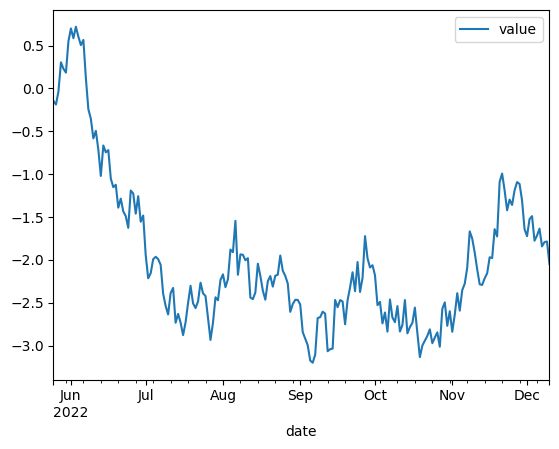

In [42]:
# Visualize the time series
ts.plot();

In [43]:
## There are no obvious signs of seasonality. Check for stationarity
# Call custom func to check if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.258272,1,198,0.185779,0.05,False


In [44]:
## Data is not stationary. How many differencing are required?
# Check differencing with ndiffs
ndiffs(ts)

1

In [45]:
# Apply one differencing and save the stationary data set for exploration
ts_diff = ts.diff().dropna()
# Confirm stationarity with adfuller test
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-15.726403,0,198,0.0,0.05,True


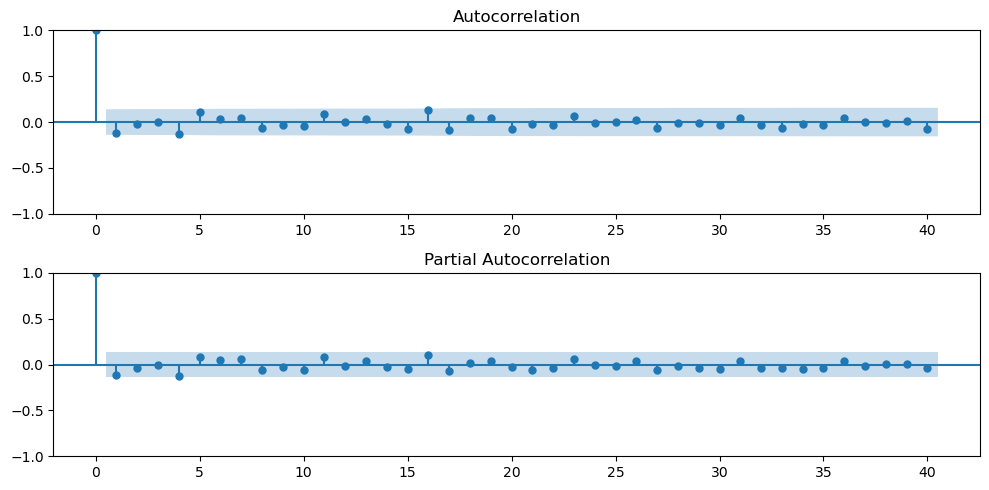

In [46]:
## Data is now stationary
# Call custom ACF/PACF function on stationary (d=1) data
plot_acf_pacf(ts_diff);

- There are no dramatic drops in either plot, so go with ARMA here. The guideline is to start with MA(1) and AR(1). TTS, and fit the model.

In [47]:
# First define the orders (p,d,q)
p = 1 # p is used for AR component of AR-MA model
d = 1 # 1 differcing needed to make stationary
q = 1 # q is used for MA component of AR-MA model
# Now instantiate the model with the data and fit
ar_ma_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_ma_model

In [48]:
## Check params to see how p=1 and q=1 affected the calculations
# Obtain parameters of the fit model
ar_ma_model.params

ar.L1    -0.629612
ma.L1     0.144928
sigma2    0.670682
dtype: float64

## Summary

- Explored MA-only models and guidelines for determining q based on the ACF plot.
- Combined MA and AR components to employ both strategies.
- A key assumption of ARIMA models is that the data is stationary; make use of ARIMA's built-in differencing feature by setting d parameter equal to 1.
- Wrote a custom function to programmatically determine significant correlations in ACF and PACF plots to assist in estimating q and p values.

# Comparing Models

- This lesson continues examining models with two key tools - the model summary and diagnostic plots.
- The example begins with the previous MA(2) model. It will show an acceptable model to keep.
- However, the summary and diagnostic plots can provide warnings to explore other options, so there will also be demonstrations of two models with warnings that these tools can identify.

## Key aread of a model summary

In [50]:
## A great deal of information about a model is in the model.summary() 
# obtain summary of model
ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -151.744
Date:                Tue, 05 Dec 2023   AIC                            311.487
Time:                        22:35:25   BIC                            323.788
Sample:                    01-31-2000   HQIC                           316.482
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1051      0.125     -0.844      0.399      -0.349       0.139
ma.L1          0.4470      0.037     12.114      0.000       0.375       0.519
ma.L2          0.9469      0.040     23.858      0.000       0.869       1.025
sigma2         0.3792      0.043      8.804      0.000       0.295       0.464
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.33   Prob(JB):                         0.99
Heteroskedasticity (H):               1.18   Skew:                             0.01
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Some of the key features of the summary table are explained below.

**Model Specification**
- The model is specified towards the top of the summary.
- **Model**: tells the configuration of the model used. The 3 numbers represent:
    - autoregressive (AR) order
    - differencing (I)
    - moving average (MA) order


### Quality of Fit

**Performance Metrics**
- Model performance metrics are on the upper right.
    - Log Likelihood: how well the model explains the data
        - Log of the Likelihood function
        - Higher value indicates better fit
        - Number should be high as possible
        - Note it's often used with other metrics, and can be influenced by the number of params chosen
    - AIC and BIC: goodness-of-fit tests
        - Lower values suggest better fit
        - AIC is usually more flexible, BIC more stringent
        - Relative metrics that can only be used to compare to other models
        - Differencing parameter, d, must be the same for relative comparisons


**Coefficients Table**
- Table is found in the middle, tells how influential each part of the model is.
- coef: coefficients of the different components of the model (AR/MA terms)
    - Effect time lag on forecasted value
    - Returns coeff for each lag
- std err: standard error of coeffs. Smaller is better
- z: Z-score. Tells how many std dev an element is from the mean.
- P-values for Coeffs (P>|z|): The p-value. Smaller p-value (< 0.05) often indicates coeff is significant.
    - These give objective measure of significance of each predictor variable.
    - Smaller p-value indicates rejection of null hypothesis that coeff is zero.
- [0.025 0.975]: this is the 95% confidence interval for each coeff


**Diagnostic Tests**

- **Ljung-Box (Q)**: Tests for remaining patterns in residuals. Higher p-values (Prob(Q)) are better, indicating model has captured an underlying process.
    - Higher p-value suggests residuals are independently distributed and that model has captured autocorrelation in the data well.
    - Low value suggests significant autocorrelation the model failed to capture.
- **Jarque-Bera (JB)**: tests if the data has skewness and kurtosis matching a normal distribution. Smaller values and higher Prob(JB) are better.
    - High value: suggests residuals are normally distributed, and model fits data well.
    - Low value: not normally distributed, model isn't capturing some aspect well.
- **Heteroskedasticity (H)**: a test to check if the variance is constant over time. A value close to 1 is ideal
- **sigma^2**: Estimated variance of the residuals (or error terms)
    - Lower values suggest the model explains a large portion of the variability in data, which is good. This value is often examined in the context of other metrics.

## Diagnostic Plots

- Second option for obtaining information about a model other than summary.

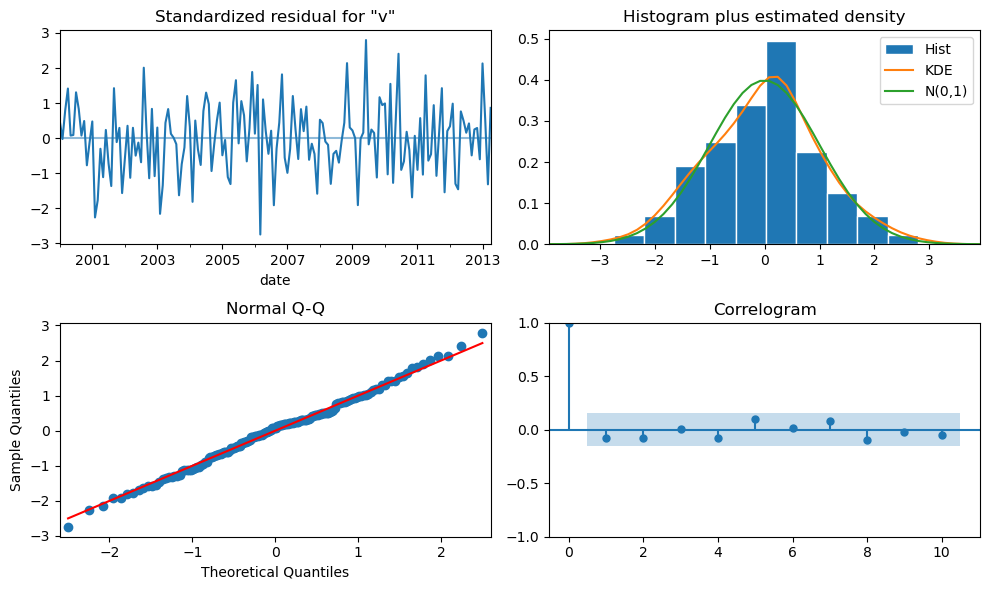

In [52]:
# Obtain diagnostic plots
fig = ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Interpreting Diagnostic Plots

#### 1. Standardized Residuals Over Time
- It shows: standardized residuals over time
- What to look for: Expect a random scatter of points; residuals are randomly scattered around zero. If there is a pattern or trend, this is a signal the model did not capture all relevant info.

#### 2. Histogram Plus Estimated Density
- It shows: Both a histogram and a smooth density line of the residuals
- What to look for: Smooth line should roughly match the shape of a standard 'bell curve'. If it does, it's a good signal residuals are normally distributed. If not, possibly investigate further.

#### 3. Normal Q-Q Plot
- It shows: quantile-quantile plot shows how the distro of the residuals compares against a standard normal distribution.
- What to look for: Points should ideally fall along 45-degree diagonal. If far from the line, especially in the tails, residuals are not normally distributed, which can impact validity of model's predictions.

#### 4. Correlogram (aka Autocorrelation Plot)
- It shows: autocorrelations of the residuals at different lags
- What to look for: Blue shade represents confidence interval. Points outside are significant. In a quality model most points fit in the blue area, indicating they are not autocorrelated.

## Try MA(1) Model to Compare

In [53]:
## Try a second model with different params. Try using an MA(1) model on the dataset. 
## To do this use q=1
# First define the orders
p=0
d=0
q=1

# Instantiate the model with the data and fit
ma_1_model = tsa.ARIMA(train, order = (p,d,q)).fit()

In [54]:
# Obtain the model summary
ma_1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -192.028
Date:                Tue, 05 Dec 2023   AIC                            390.055
Time:                        23:15:01   BIC                            399.281
Sample:                    01-31-2000   HQIC                           393.801
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1047      0.076     -1.379      0.168      -0.254       0.044
ma.L1          0.1920      0.076      2.517      0.012       0.042       0.342
sigma2         0.6455      0.085      7.569      0.000       0.478       0.813
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.33   Prob(JB):                         0.39
Heteroskedasticity (H):               0.97   Skew:                            -0.02
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Explore the AIC and BIC scores in a separate section later in the lesson.
- Here, focus on plot diagnostics for the new MA(1) model.

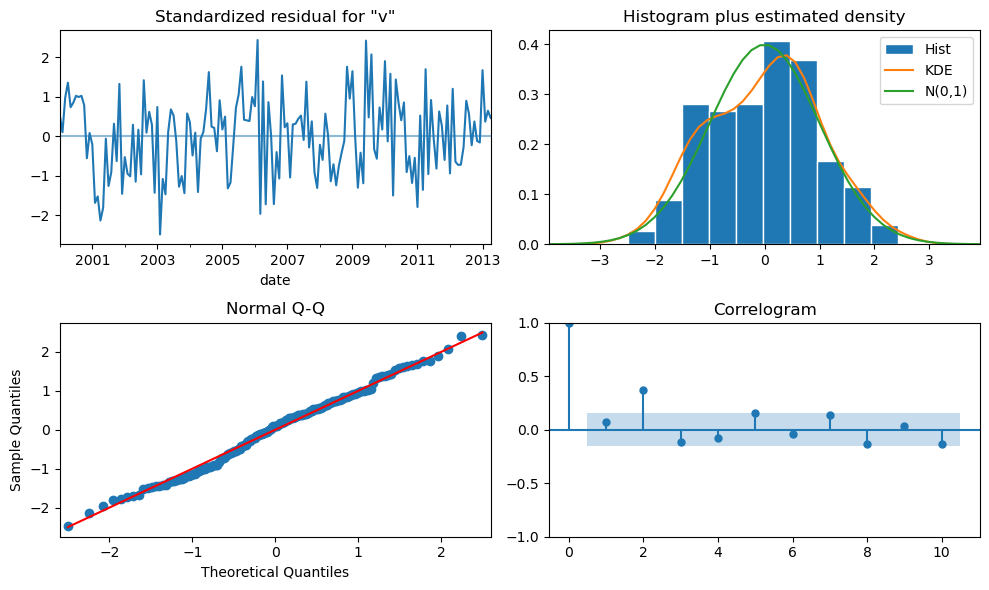

In [55]:
# Obtain diagnostic plots
fig = ma_1_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- The most noteworthy feature in the figures it the outlying point in the Correlogram, which indicates our model has missed something.

## Try AR(1) MA(2) Model to Compare

- Try another model to see an example of how to learn from the summary and diagnostic plots.
- This time, check what happens if AR is added with p=1

In [56]:
# First define the orders
p=1
d=0
q=2
# Insantiate the model with data and fit
ar_1_ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()

In [59]:
# Check the summary
ar_1_ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -151.097
Date:                Tue, 05 Dec 2023   AIC                            312.193
Time:                        23:58:29   BIC                            327.569
Sample:                    01-31-2000   HQIC                           318.437
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1060      0.111     -0.953      0.340      -0.324       0.112
ar.L1         -0.1002      0.090     -1.112      0.266      -0.277       0.076
ma.L1          0.4705      0.028     16.983      0.000       0.416       0.525
ma.L2          0.9721      0.036     26.767      0.000       0.901       1.043
sigma2         0.3733      0.042      8.804      0.000       0.290       0.456
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.94   Prob(JB):                         0.91
Heteroskedasticity (H):               1.15   Skew:                             0.08
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The model has added an AR coeff, but the p-value is high enough that it is not significant, meaning it could be removed from the model and it would still be as accurate.
- Try examining the plot diagnostics.

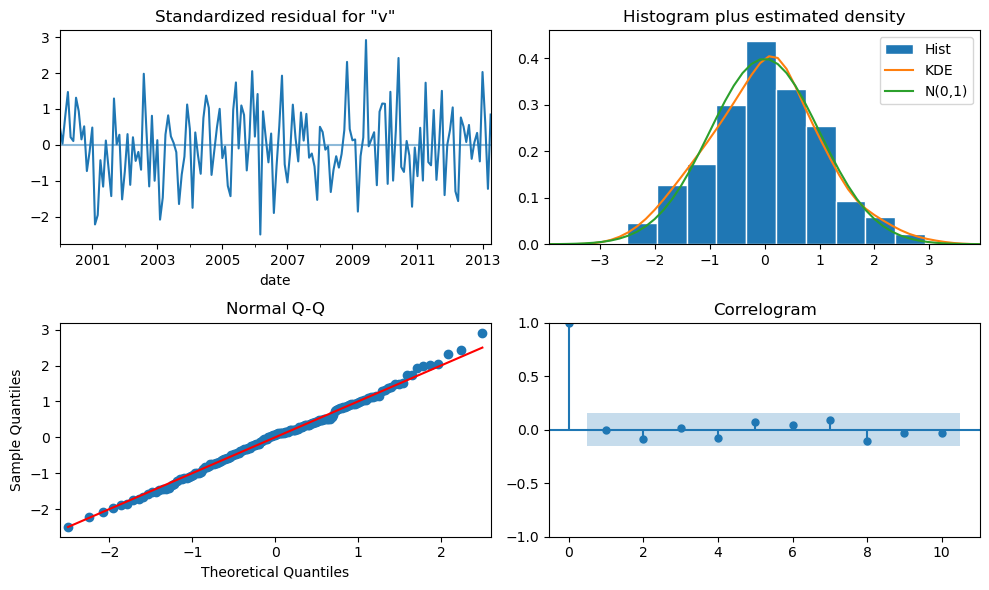

In [61]:
# Obtain diagnostic plots
fig = ar_1_ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- In this case, there is nothing of note.
- Both the summary and diagnostics plot should be examined when understanding a model.

**AIC and BIC**
- Although available in the summary, the values can be found with model.aic or model.bic

In [62]:
### Compare AIC and BIC on three models
## AIC
# look up three models
print(f'MA(2) had an AIC of {ma_2_model.aic.round(2)}')
print(f'MA(1) had an AIC of {ma_1_model.aic.round(2)}')
print(f'AR(1)MA(2) had an AIC of {ar_1_ma_2_model.aic.round(2)}')

MA(2) had an AIC of 311.49
MA(1) had an AIC of 390.06
AR(1)MA(2) had an AIC of 312.19


- MA(2) had the lowest score, but only beat out the second model by around one point

In [64]:
## BIC
# Looking at BIC of all three models
print(f'MA(2) had a BIC of {ma_2_model.bic.round(2)}')
print(f'MA(1) had a BIC of {ma_1_model.bic.round(2)}')
print(f'AR(1)MA(2) had a BIC of {ar_1_ma_2_model.bic.round(2)}')

MA(2) had a BIC of 323.79
MA(1) had a BIC of 399.28
AR(1)MA(2) had a BIC of 327.57


- The lowest BIC score was for the MA(2) model

**Conflicting AIC and BIC: When to trust one or the other**

- If there are:
    - Large sample sizes:
        - BIC is generally recommended - heavily penalizes extra params, reduces overfitting chances
    - Smaller sample size or More Complexity:
        - AIC may be better
        - Less strict about penalizing complexity
    - Business Case:
        - If more concerned about predictive accuracy, AIC may be more appropriate.
        - If more concerned about a model that is easy to interpret, consider BIC.

## Summary

- Explored model summary and diagnostic plots.
- Examined AIC and BIC and when to chose either.